In [1]:
# import pertinent libraries
import os
import sys
import datetime
import glob as glob
import numpy as np
import cv2
# [Keras Models]
# import the Keras implementations of VGG16, VGG19, InceptionV3 and Xception models
# the model used here is VGG16
from keras.applications.vgg19 import VGG19, preprocess_input
from keras.models import Model, Sequential
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Add, GlobalAvgPool2D, Flatten
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow import keras
import tensorflow
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import classification_report, confusion_matrix


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
img_width, img_height = 224, 224

train_dir = '/content/drive/MyDrive/Data_Sets_of_abnormality_in_large_intestine/kvasir_dataset_v2/train'
validate_dir = '/content/drive/MyDrive/Data_Sets_of_abnormality_in_large_intestine/kvasir_dataset_v2/val'
test_dir = '/content/drive/MyDrive/Data_Sets_of_abnormality_in_large_intestine/kvasir_dataset_v2/test'
nb_epochs = 5
batch_size = 32
nb_classes = len(glob.glob(train_dir + '/*'))

# get number of images in training directory
nb_train_samples = 0
for r, dirs, files in os.walk(train_dir):
    for dr in dirs:
        nb_train_samples += len(glob.glob(os.path.join(r, dr + "/*")))
# get number of images in validation directory
nb_validate_samples = 0
for r, dirs, files in os.walk(validate_dir):
    for dr in dirs:
        nb_validate_samples += len(glob.glob(os.path.join(r, dr + "/*")))
# get the number of images in test directory
nb_test_samples = 0
for r, dirs, files in os.walk(test_dir):
    for dr in dirs:
        nb_test_samples += len(glob.glob(os.path.join(r, dr + "/*")))

In [4]:
print(nb_classes)

8


In [9]:
# Data preprocessing for training
train_datagen =  ImageDataGenerator(
    rotation_range = 20,
    fill_mode = 'nearest',
    horizontal_flip = True)

In [10]:
# data pre-processing for validation
validate_datagen =  ImageDataGenerator(
    rotation_range = 20,
    fill_mode = 'nearest',
    horizontal_flip = True)

In [11]:
# data pre-processing for testing
test_datagen =  ImageDataGenerator(
    rotation_range = 20,
    fill_mode = 'nearest',
    horizontal_flip = True)

In [12]:
# generate and store training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size)

Found 6400 images belonging to 8 classes.


In [13]:
# generate and store validation data
validate_generator = validate_datagen.flow_from_directory(
    validate_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size)

Found 810 images belonging to 8 classes.


In [14]:
# generate and store test data
test_generator = validate_datagen.flow_from_directory(
    test_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size)

Found 800 images belonging to 8 classes.


In [15]:
vgg_16_model = Sequential()

pretrained_model = tf.keras.applications.VGG16(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=(224,224,3),
    pooling='maxpool'
)

vgg_16_model.add(pretrained_model)
vgg_16_model.add(GlobalAvgPool2D())
vgg_16_model.add(Flatten())
vgg_16_model.add(Dropout(0.5))
vgg_16_model.add(Dense(8, activation = 'softmax'))

58889256/58889256 [==============================] - 2s 0us/step


In [16]:
vgg_16_model.compile(Adam(learning_rate = 0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [17]:
vgg_16_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 8)                 4104      
                                                                 
Total params: 14,718,792
Trainable params: 14,718,792
Non-trainable params: 0
____________________________________________

In [18]:
# Currently skipped, will be used later
early_stopping = tf.keras.callbacks.EarlyStopping(
                          monitor= "val_loss",
                          patience = 2)

In [19]:
# fit the model, log the results and the training time
now = datetime.datetime.now
t = now()
transfer_learning_history = vgg_16_model.fit_generator(
    train_generator,
    epochs = nb_epochs,
    steps_per_epoch = nb_train_samples//batch_size,
    validation_data = validate_generator,
    validation_steps = nb_validate_samples//batch_size)
print('Training time: %s' % (now() - t))

<ipython-input-19-8af4685f2f28>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  transfer_learning_history = vgg_16_model.fit_generator(


Epoch 1/5
200/200 [==============================] - 3495s 17s/step - loss: 1.9727 - accuracy: 0.2186 - val_loss: 1.2048 - val_accuracy: 0.4900
Epoch 2/5
200/200 [==============================] - 214s 1s/step - loss: 1.0127 - accuracy: 0.5467 - val_loss: 0.8096 - val_accuracy: 0.5962
Epoch 3/5
200/200 [==============================] - 213s 1s/step - loss: 0.7632 - accuracy: 0.6575 - val_loss: 0.7164 - val_accuracy: 0.7075
Epoch 4/5
200/200 [==============================] - 212s 1s/step - loss: 0.6218 - accuracy: 0.7348 - val_loss: 0.8876 - val_accuracy: 0.5537
Epoch 5/5
200/200 [==============================] - 212s 1s/step - loss: 0.5165 - accuracy: 0.7819 - val_loss: 1.6958 - val_accuracy: 0.6100
Training time: 1:12:43.011770


In [20]:
model = vgg_16_model.save("vgg_16.h5")

In [21]:
from keras import models
model = models.load_model("vgg_16.h5")

In [22]:
score = vgg_16_model.evaluate_generator(validate_generator, nb_validate_samples/batch_size)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

<ipython-input-22-571fe7bb1dd5>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  score = vgg_16_model.evaluate_generator(validate_generator, nb_validate_samples/batch_size)


Test Score: 1.780839204788208
Test Accuracy: 0.5901234745979309


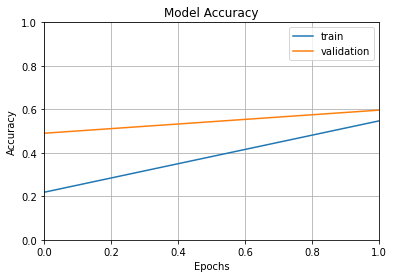

In [23]:
fig1 = plt.gcf()
plt.plot(transfer_learning_history.history["accuracy"])
plt.plot(transfer_learning_history.history["val_accuracy"])
plt.axis(ymin = 0.0, ymax = 1.0)
plt.axis(xmin = 0.0, xmax = 1.0)
plt.grid()
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["train", "validation"])
plt.show()

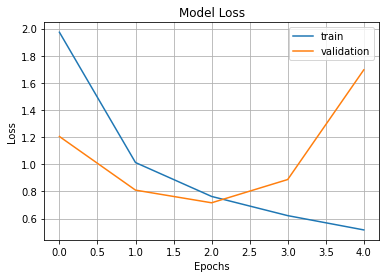

In [24]:
plt.plot(transfer_learning_history.history["loss"])
plt.plot(transfer_learning_history.history["val_loss"])
plt.grid()
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(["train", "validation"])
plt.show()

In [25]:
X_test, Y_test = next(test_generator)

In [26]:
print(X_test,Y_test)

[[[[1.90000000e+01 1.90000000e+01 1.90000000e+01]
   [1.90000000e+01 1.90000000e+01 1.90000000e+01]
   [1.90000000e+01 1.90000000e+01 1.90000000e+01]
   ...
   [1.90000000e+01 1.90000000e+01 1.90000000e+01]
   [1.90000000e+01 1.90000000e+01 1.90000000e+01]
   [1.90000000e+01 1.90000000e+01 1.90000000e+01]]

  [[1.90000000e+01 1.90000000e+01 1.90000000e+01]
   [1.90000000e+01 1.90000000e+01 1.90000000e+01]
   [1.90000000e+01 1.90000000e+01 1.90000000e+01]
   ...
   [1.90000000e+01 1.90000000e+01 1.90000000e+01]
   [1.90000000e+01 1.90000000e+01 1.90000000e+01]
   [1.90000000e+01 1.90000000e+01 1.90000000e+01]]

  [[1.90000000e+01 1.90000000e+01 1.90000000e+01]
   [1.90000000e+01 1.90000000e+01 1.90000000e+01]
   [1.90000000e+01 1.90000000e+01 1.90000000e+01]
   ...
   [1.90000000e+01 1.90000000e+01 1.90000000e+01]
   [1.90000000e+01 1.90000000e+01 1.90000000e+01]
   [1.90000000e+01 1.90000000e+01 1.90000000e+01]]

  ...

  [[1.90000000e+01 1.90000000e+01 1.90000000e+01]
   [1.90000000e+

In [27]:
y_true=[]
for i in range(len(Y_test)):
    K= Y_test[i]
    
    y_true.append(list(K).index(max(list(K))))

In [28]:
print(y_true)

[4, 7, 5, 3, 0, 0, 4, 7, 4, 4, 3, 0, 1, 7, 6, 3, 3, 0, 0, 5, 3, 1, 4, 1, 5, 2, 4, 0, 6, 1, 5, 5]


In [29]:
M = vgg_16_model.predict(X_test)
X_t=[]
for i in range(len(M)):
    K= M[i]
    X_t.append(list(K).index(max(list(K))))

1/1 [==============================] - 0s 188ms/step


In [30]:
print(X_t)

[4, 7, 2, 3, 0, 0, 4, 7, 4, 4, 3, 0, 1, 7, 6, 3, 7, 0, 0, 2, 3, 1, 2, 1, 5, 2, 4, 0, 1, 1, 2, 2]


In [31]:
print(classification_report(y_true, X_t, zero_division = 0))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       0.80      1.00      0.89         4
           2       0.17      1.00      0.29         1
           3       1.00      0.80      0.89         5
           4       1.00      0.83      0.91         6
           5       1.00      0.20      0.33         5
           6       1.00      0.50      0.67         2
           7       0.75      1.00      0.86         3

    accuracy                           0.78        32
   macro avg       0.84      0.79      0.73        32
weighted avg       0.93      0.78      0.79        32



In [32]:
print(confusion_matrix(y_true,X_t))

[[6 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0]
 [0 0 0 4 0 0 0 1]
 [0 0 1 0 5 0 0 0]
 [0 0 4 0 0 1 0 0]
 [0 1 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 3]]
